In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [41]:
#rankings data with beer_location and user_location added as extra columns
BA_merged = pd.read_csv('../../minimizedData/BA_ratings_small_plus.csv')

In [42]:
print(BA_merged.shape)
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
print(US_ratings.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]
US_ratings.head(2)

(8393032, 15)
(7892754, 15)


,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.5,4.00,4.0,3.75,3.75,3.76,"United States, North Carolina",3.76,"United States, Wisconsin"
1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.0,3.75,4.0,3.50,3.50,3.58,"United States, North Carolina",3.58,"United States, Wisconsin"


In [43]:
#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')] #remove lines where there is no specific state in user_state or beer_state
print(US_ratings.shape)

US_ratings.head(2)

(6331638, 15)


,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,avg,user_state,beer_state
1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.5,4.00,4.0,3.75,3.75,3.76,3.76,North Carolina,Wisconsin
1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.0,3.75,4.0,3.50,3.50,3.58,3.58,North Carolina,Wisconsin


In [52]:
neighbours_df = pd.read_csv('../../additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
neighbours_df["neighbours"] = neighbours_df["neighbours"].fillna("").apply(lambda x: x.split(";") if x else [])


cohen_results_by_region = {}

def cohen_d(x, y):
    x, y = np.array(x, dtype=float), np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x**2 + (ny - 1) * std_y**2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

for index, row in neighbours_df.iterrows():
    state = row['state']
    neighbours = row['neighbours']

    if neighbours:
        region_states = [state] + neighbours
    else:
        region_states = [state] #if a state doesn't have neighbours we consider it as a region (like Alaska and Hawaii)

    in_region_ratings = US_ratings[US_ratings['user_state'].isin(region_states)]['rating'] #take only the ratings of states inside the region
    out_of_region_ratings = US_ratings[~US_ratings['user_state'].isin(region_states)]['rating'] #take only the ratings of states outside the region

    if len(in_region_ratings) < 2 or len(out_of_region_ratings) < 2: #in order to do correctly the cohen test
        cohen_results_by_region[state] = np.nan
        continue

    d_value = cohen_d(in_region_ratings, out_of_region_ratings)
    cohen_results_by_region[state] = d_value

#table to see the Cohen factor for each region
cohen_by_region_df = pd.DataFrame.from_dict(cohen_results_by_region, orient='index', columns=['Cohen_d'])
cohen_by_region_df.index.name = 'Center State of each Region'
cohen_by_region_df = cohen_by_region_df.reset_index()

print(cohen_by_region_df)

   Center State of each Region   Cohen_d
0                      Alabama -0.036738
1                       Alaska  0.063092
2                      Arizona  0.058747
3                     Arkansas -0.075343
4                   California  0.068791
5                     Colorado -0.035901
6                  Connecticut  0.059749
7                     Delaware -0.057938
8                      Florida -0.013167
9                      Georgia -0.014737
10                      Hawaii -0.073885
11                       Idaho -0.067379
12                    Illinois  0.018308
13                     Indiana  0.022467
14                        Iowa  0.030385
15                      Kansas -0.043471
16                    Kentucky  0.007034
17                   Louisiana -0.074046
18                       Maine  0.031355
19                    Maryland -0.064349
20               Massachusetts  0.067395
21                    Michigan  0.029781
22                   Minnesota -0.009769
23              

C:\Users\helen\AppData\Local\Temp\ipykernel_32656\3693594445.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cohen_by_region_df, x='Center State of each Region', y='Cohen_d', palette='viridis')


<Figure size 1400x800 with 0 Axes>

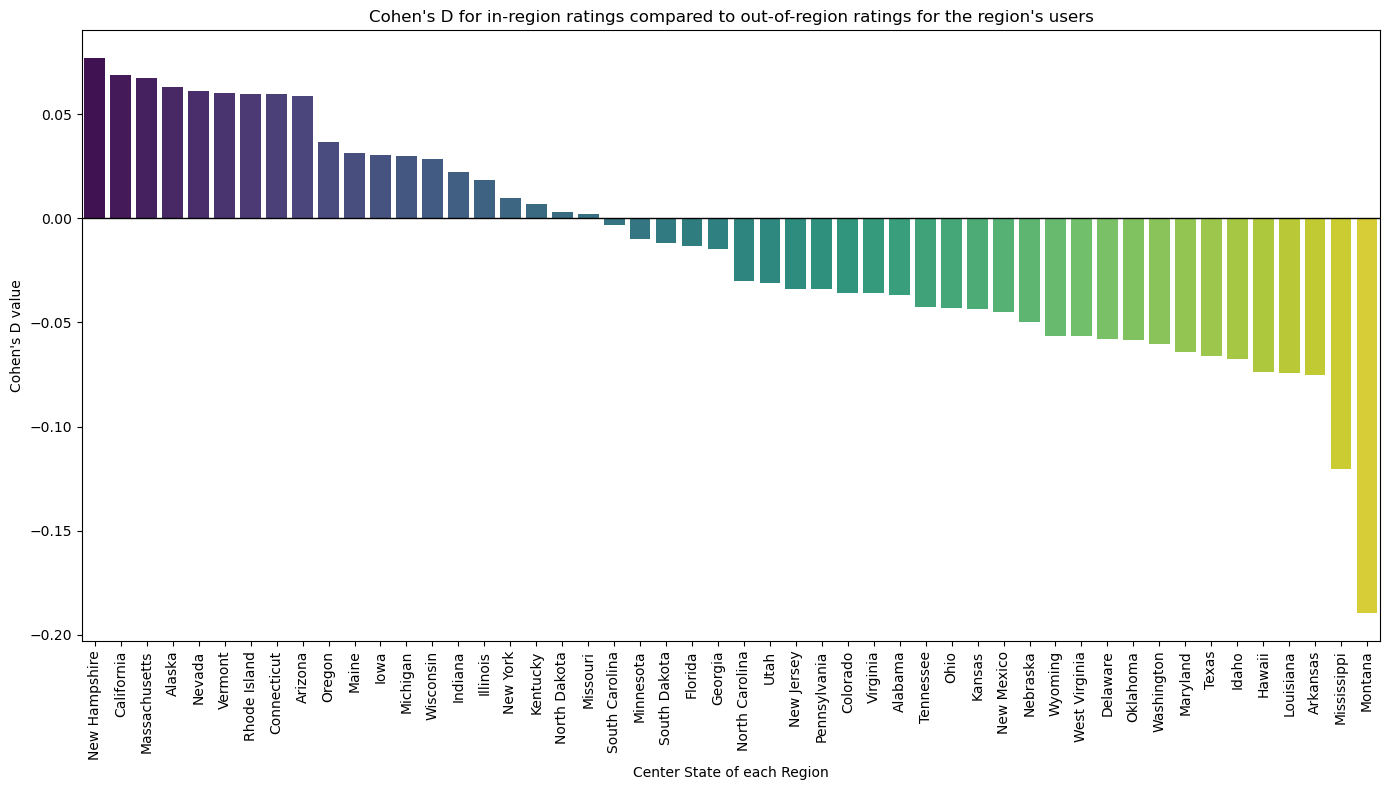

In [54]:
cohen_by_region_df = cohen_by_region_df.sort_values(by='Cohen_d', ascending=False)


plt.figure(figsize=(14, 8))
sns.barplot(data=cohen_by_region_df, x='Center State of each Region', y='Cohen_d', palette='viridis')
plt.title("Cohen's D for in-region ratings compared to out-of-region ratings for the region's users")
plt.xlabel("Center State of each Region")
plt.ylabel("Cohen's D value")
plt.xticks(rotation=90)
plt.axhline(y=0, color='black', linewidth=1)
plt.tight_layout()
plt.show()